In [1]:
import sys
sys.path.append('/home/ubuntu/anaconda3/lib/python3.6/site-packages')
import dgl
import gluoncv as gcv
import mxnet as mx
import numpy as np
import logging, time
from operator import itemgetter
from mxnet import nd, gluon
from mxnet.gluon import nn
from dgl.utils import toindex
from dgl.nn.mxnet import GraphConv
from gluoncv.model_zoo import get_model

In [2]:
class SoftmaxHD(nn.HybridBlock):
    """Softmax on multiple dimensions
    Parameters
    ----------
    axis : the axis for softmax normalization
    """
    def __init__(self, axis=(2, 3), **kwargs):
        super(SoftmaxHD, self).__init__(**kwargs)
        self.axis = axis

    def hybrid_forward(self, F, x):
        x_max = F.max(x, axis=self.axis, keepdims=True)
        x_exp = F.exp(F.broadcast_minus(x, x_max))
        norm = F.sum(x_exp, axis=self.axis, keepdims=True)
        res = F.broadcast_div(x_exp, norm)
        return res

class EdgeLinkMLP(nn.Block):
    def __init__(self, n_hidden, n_classes):
        super(EdgeLinkMLP, self).__init__()
        self.mlp1 = nn.Dense(n_hidden)
        self.relu1 = nn.Activation('relu')
        self.mlp2 = nn.Dense(n_hidden)
        self.relu2 = nn.Activation('relu')
        self.mlp3 = nn.Dense(n_classes)

    def forward(self, edges):
        feat = nd.concat(edges.src['node_class_prob'], edges.src['pred_bbox'],
                         edges.dst['node_class_prob'], edges.dst['pred_bbox'])
        out = self.relu1(self.mlp1(feat))
        out = self.relu2(self.mlp2(out))
        out = self.mlp3(out)
        return {'link_preds': out}

class EdgeMLP(nn.Block):
    def __init__(self, n_hidden, n_classes):
        super(EdgeMLP, self).__init__()
        self.mlp1 = nn.Dense(n_hidden)
        self.relu1 = nn.Activation('relu')
        self.mlp2 = nn.Dense(n_hidden)
        self.relu2 = nn.Activation('relu')
        self.mlp3 = nn.Dense(n_classes)

    def forward(self, edges):
        feat = nd.concat(edges.src['node_class_prob'], edges.src['emb'], edges.src['pred_bbox'],
                         edges.dst['node_class_prob'], edges.dst['emb'], edges.dst['pred_bbox'])
        out = self.relu1(self.mlp1(feat))
        out = self.relu2(self.mlp2(out))
        out = self.mlp3(out)
        return {'preds': out}

class EdgeGCN(nn.Block):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 box_feat_ext,
                 pretrained_base=True,
                 ctx=mx.cpu()):
        super(EdgeGCN, self).__init__()
        self.layers = nn.Sequential()
        # input layer
        self.layers.add(GraphConv(in_feats, n_hidden, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.edge_link_mlp = EdgeLinkMLP(50, 2)
        self.edge_mlp = EdgeMLP(100, n_classes)
        # self._box_feat_ext = get_model(box_feat_ext, pretrained=pretrained_base, ctx=ctx).features[:-2]
        self._softmax = SoftmaxHD(axis=(1))

    def forward(self, g):
        if g is None or g.number_of_nodes() == 0:
            return g
        cls = g.ndata['node_class_pred']
        g.ndata['node_class_prob'] = self._softmax(cls)
        # link pred
        g.apply_edges(self.edge_link_mlp)
        eids = np.where(nd.softmax(g.edata['link_preds'])[:,1].asnumpy() > 0.1)
        sub_g = g.edge_subgraph(toindex(eids[0].tolist()))
        sub_g.copy_from_parent()
        x = sub_g.ndata['node_feat']
        for i, layer in enumerate(self.layers):
            x = layer(sub_g, x)
        sub_g.ndata['emb'] = x
        sub_g.apply_edges(self.edge_mlp)
        sub_g.copy_to_parent()
        '''
        # graph conv
        x = g.ndata['node_feat']
        for i, layer in enumerate(self.layers):
            x = layer(g, x)
        g.ndata['emb'] = x
        # link classification
        g.apply_edges(self.edge_mlp)
        '''
        return g

In [4]:
N_relations = 50
N_objects = 150
ctx=mx.cpu()

net = EdgeGCN(in_feats=49, n_hidden=32, n_classes=N_relations,
              n_layers=2, activation=nd.relu,
              box_feat_ext='mobilenet1.0', pretrained_base=False, ctx=ctx)
'''
# net.initialize(ctx=ctx)
net._box_feat_ext.hybridize()
net.edge_mlp.initialize(ctx=ctx)
net.edge_link_mlp.initialize(ctx=ctx)
net.layers.initialize(ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adam',
                        {'learning_rate': 0.01, 'wd': 0.00001})
for k, v in net._box_feat_ext.collect_params().items():
    v.grad_req = 'null'
'''
net.load_parameters('params/model-1.params', ctx=ctx)

In [5]:
@mx.metric.register
@mx.metric.alias('auc')
class AUCMetric(mx.metric.EvalMetric):
    def __init__(self, eps=1e-12):
        super(AUCMetric, self).__init__(
              'auc')
        self.eps = eps

    def update(self, labels, preds):
        mx.metric.check_label_shapes(labels, preds)
        label_weight = labels[0].asnumpy()
        preds = preds[0].asnumpy()
        tmp = []
        for i in range(preds.shape[0]):
            tmp.append((label_weight[i], preds[i][1]))
        tmp = sorted(tmp, key=itemgetter(1), reverse=True)
        label_sum = label_weight.sum()
        if label_sum == 0 or label_sum == label_weight.size:
            raise Exception("AUC with one class is undefined")

        label_one_num = np.count_nonzero(label_weight)
        label_zero_num = len(label_weight) - label_one_num
        total_area = label_zero_num * label_one_num
        height = 0
        width = 0
        area = 0
        for a, _ in tmp:
            if a == 1.0:
                height += 1.0
            else:
                width += 1.0
                area += height

        self.sum_metric += area / total_area
        self.num_inst += 1

In [10]:
def _build_complete_graph(bbox, scores, img, feat_ind, spatial_feat, cls_pred, thr=0.5):
    bbox_list = []
    bbox_np_list = []
    roi_ind = []
    detect_ind = []
    for i in range(bbox.shape[0]):
        if scores[i] > thr:
            detect_ind.append(i)
            bbox_list.append(bbox[i])
            bbox_np_list.append(bbox[i].asnumpy())
            roi_ind.append(int(feat_ind[i].asscalar()))

    N = len(bbox_list)
    bbox = mx.nd.stack(*bbox_list)
    g = dgl.DGLGraph()
    g.add_nodes(N)
    edge_list = []
    for i in range(N-1):
        for j in range(i+1, N):
            edge_list.append((i, j))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)

    img_list = crop_resize_normalize(img, bbox_np_list, (224, 224))
    node_imgs = mx.nd.stack(*img_list)

    img_shape = x.shape
    bbox[:,0] /= img_shape[3]
    bbox[:,1] /= img_shape[2]
    bbox[:,2] /= img_shape[3]
    bbox[:,3] /= img_shape[2]
    g.ndata['pred_bbox'] = bbox
    # g.ndata['images'] = node_imgs
    g.ndata['node_feat'] = spatial_feat[roi_ind,]
    g.ndata['node_class_pred'] = cls_pred[roi_ind,]
    return g, detect_ind

In [8]:
vg_val = gcv.data.VGRelation(top_frequent_rel=N_relations, top_frequent_obj=N_objects,
                             balancing='weight', split='val')

In [9]:
batch_size = 1
from gluoncv.data import dataloader
val_data = gluon.data.DataLoader(vg_val, batch_size=batch_size, shuffle=False, num_workers=60,
                                 batchify_fn=dataloader.dgl_mp_batchify_fn)
class_names = vg_val._obj_classes
rel_names = vg_val._relations

In [11]:
detector = get_model('faster_rcnn_resnet50_v1b_custom', classes=class_names,
                     pretrained_base=False, pretrained=False, additional_output=True)
params_path = 'faster_rcnn_resnet50_v1b_custom_0007_0.2398.params'
detector.load_parameters(params_path, ctx=ctx, ignore_extra=True, allow_missing=True)

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
plt.rcParams["figure.figsize"]=10,10

x, orig_img = gcv.data.transforms.presets.rcnn.load_test('running.jpg')

plt.imshow(orig_img)
plt.show()

<Figure size 1000x1000 with 1 Axes>

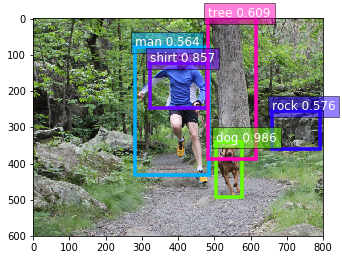

In [13]:
box_ids, scores, bboxes, feat, feat_ind, spatial_feat, cls_pred = detector(x)
ax = gcv.utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=class_names)

plt.show()

In [14]:
from gluoncv.data.transforms.pose import crop_resize_normalize
g, detect_ind = _build_complete_graph(bboxes[0], scores[0], orig_img, feat_ind[0], spatial_feat[0], cls_pred[0])

In [15]:
g

DGLGraph(num_nodes=5, num_edges=20,
         ndata_schemes={'pred_bbox': Scheme(shape=(4,), dtype=<class 'numpy.float32'>), 'node_feat': Scheme(shape=(49,), dtype=<class 'numpy.float32'>), 'node_class_pred': Scheme(shape=(151,), dtype=<class 'numpy.float32'>)}
         edata_schemes={})

In [16]:
g = net(g)

In [17]:
g

DGLGraph(num_nodes=5, num_edges=20,
         ndata_schemes={'pred_bbox': Scheme(shape=(4,), dtype=<class 'numpy.float32'>), 'node_feat': Scheme(shape=(49,), dtype=<class 'numpy.float32'>), 'node_class_pred': Scheme(shape=(151,), dtype=<class 'numpy.float32'>), 'node_class_prob': Scheme(shape=(151,), dtype=<class 'numpy.float32'>), 'emb': Scheme(shape=(32,), dtype=<class 'numpy.float32'>)}
         edata_schemes={'link_preds': Scheme(shape=(2,), dtype=<class 'numpy.float32'>), 'preds': Scheme(shape=(50,), dtype=<class 'numpy.float32'>)})

In [18]:
link_prob = nd.softmax(g.edata['link_preds'])[:,1].asnumpy()
prob_thresh = 0.1
eid_above_thresh = np.where(link_prob > prob_thresh)[0]
eid = link_prob.argsort()[::-1][0:len(eid_above_thresh)]

In [19]:
node_ids = g.find_edges(eid)
node_src = node_ids[0].asnumpy()
node_dst = node_ids[1].asnumpy()

In [37]:
for i in range(15):
    bbox_ind = [node_src[i], node_dst[i]]

    sub_node_ind = int(box_ids[0][detect_ind[node_src[i]]].asscalar())
    ob_node_ind = int(box_ids[0][detect_ind[node_dst[i]]].asscalar())
    sub = class_names[sub_node_ind]
    ob = class_names[ob_node_ind]

    rel_prob = nd.softmax(g.edata['preds'][eid[i]]).asnumpy()
    rel_ind = rel_prob.argsort()[::-1]
    rel = rel_names[rel_ind[0]]

    prob = scores[0, detect_ind[node_src[i]], 0].asscalar()
    prob *= scores[0, detect_ind[node_dst[i]], 0].asscalar()
    prob *= link_prob[eid[i]]
    prob *= rel_prob[rel_ind[0]]
    
    print("Relationship: <%s> <%s> <%s> with probability %f"%(sub, rel, ob, prob))

Relationship: <man> <wear> <shirt> with probability 0.273098
Relationship: <tree> <behind> <man> with probability 0.102699
Relationship: <tree> <behind> <dog> with probability 0.071828
Relationship: <tree> <along> <rock> with probability 0.040473
Relationship: <shirt> <along> <man> with probability 0.151925
Relationship: <man> <have> <dog> with probability 0.055885
Relationship: <rock> <along> <tree> with probability 0.026326
Relationship: <dog> <in> <tree> with probability 0.062882
Relationship: <dog> <in> <man> with probability 0.060045
Relationship: <tree> <have> <shirt> with probability 0.091679
Relationship: <man> <have> <tree> with probability 0.020976
Relationship: <dog> <along> <rock> with probability 0.066299
Relationship: <man> <have> <rock> with probability 0.013460
Relationship: <rock> <behind> <man> with probability 0.014738
Relationship: <shirt> <along> <tree> with probability 0.043584


Relationship: <rock> <behind> <dog>

Probabilities:
The subject being <rock> is 0.575865
The object being <dog> is 0.985602
Having the link is 0.109985
    - The link being <behind> is 0.339424
    - The link being <about> is 0.156401
    - The link being <be> is 0.148009
    - The link being <next> is 0.099182
    - The link being <have> is 0.062244


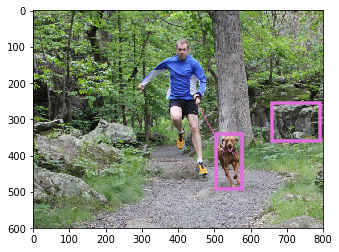

In [34]:
i = 15
bbox_ind = [node_src[i], node_dst[i]]

sub_node_ind = int(box_ids[0][detect_ind[node_src[i]]].asscalar())
ob_node_ind = int(box_ids[0][detect_ind[node_dst[i]]].asscalar())
sub = class_names[sub_node_ind]
ob = class_names[ob_node_ind]

rel_prob = nd.softmax(g.edata['preds'][eid[i]]).asnumpy()
rel_ind = rel_prob.argsort()[::-1]
rel = rel_names[rel_ind[0]]

print("Relationship: <%s> <%s> <%s>\n"%(sub, rel, ob))
print("Probabilities:")
print('The subject being <%s> is %f'%(sub, scores[0, detect_ind[node_src[i]], 0].asscalar()))
print('The object being <%s> is %f'%(ob, scores[0, detect_ind[node_dst[i]], 0].asscalar()))
print('Having the link is %f'%(link_prob[eid[i]]))
for j in range(5):
    print('    - The link being <%s> is %f'%(rel_names[rel_ind[j]], rel_prob[rel_ind[j]]))

ax = gcv.utils.viz.plot_bbox(orig_img, mx.nd.array(g.ndata['pred_bbox'][bbox_ind,:]), absolute_coordinates=False)
plt.show()